# What is the COVID-19/Coronavirus?
 * According to the CDC, "Coronavirus disease (COVID-19) is an infectious disease caused by a newly discovered coronavirus. Most people infected with the COVID-19 virus will experience mild to moderate respiratory illness and recover without requiring special treatment. Older people, and those with underlying medical problems like cardiovascular disease, diabetes, chronic respiratory disease, and cancer are more likely to develop serious illness." 
 
* Continuing, "The best way to prevent and slow down transmission is to be well informed about the COVID-19 virus, the disease it causes and how it spreads. Protect yourself and others from infection by washing your hands or using an alcohol based rub frequently and not touching your face."



<h2> Table of Contents </h2>

<ol style="font-size: 16px">
    <li> <a href="https://www.kaggle.com/ironicninja/covid-19-every-day/notebook#gather">Gathering the Data</a> </li>
    <li> <a href="https://www.kaggle.com/ironicninja/covid-19-every-day/notebook#general">General Visualizations </a> </li>
    <li> <a href="https://www.kaggle.com/ironicninja/covid-19-every-day/notebook#continent">By Continent </a> </li>
    <li> <a href="https://www.kaggle.com/ironicninja/covid-19-every-day/notebook#countries"> By Country </a> </li>
</ol>

<h2> Starred Visualiztions </h2>
<ol style="font-size: 16px">
    <ul> <a href="https://www.kaggle.com/ironicninja/covid-19-every-day/notebook#country-search">Interactive Search for Stats by Your Country </a> </ul>
</ol>
    
    Special thanks to @JR12DER for catching a mistake with the intearctive graphs. They are now fixed.

In [1]:

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [2]:
!pip install bs4

from bs4 import BeautifulSoup as soup
from urllib.request import Request, urlopen
from datetime import date, datetime
fname = 'https://www.worldometers.info/coronavirus/'
req = Request(fname, headers={'User-Agent': 'Mozilla/5.0'})
webpage = urlopen(req)
page_soup = soup(webpage, "html.parser")

In [3]:
today = datetime.now()
now_str = "%s %d, %d at %d:%s" % (date.today().strftime("%b"), today.day, today.year, today.hour, '0'+str(today.minute) if today.minute < 10 else str(today.minute))
containers = page_soup.findAll("div", {"class": "maincounter-number"})
print("As of %s UTC, there have been %s total COVID-19 cases." % (now_str, containers[0].findAll("span")[0].text.replace(' ', '')))

As of Feb 13, 2021 at 19:45 UTC, there have been 108,921,635 total COVID-19 cases.


Hopefully now you think you should care. Crazy numbers, right? Before we get started, please **"leave an upvote"**  if you think this notebook is a valuable resource. I
would love if this could become a community project, and upvoting helps with the publicity. Anyways, now, without further ado, let's get started!

<h1 class="alert alert-block alert-info" style="text-align:center; font-size:24px" id="gather">Gathering the Data (Web Scraping)<a class="anchor-link" href="https://www.kaggle.com/ironicninja/covid-19-every-day/notebook#gather">¶</a></h1>

In [4]:
from bs4 import BeautifulSoup as soup
from urllib.request import Request, urlopen
import pandas as pd
import numpy as np
from datetime import date, datetime
import matplotlib.pyplot as plt
import gc #garbage collector
import plotly.graph_objects as go
import plotly.offline as py
py.init_notebook_mode(connected=True)
import seaborn as sns

# <h1> Web Scraping Foundation </h1>

In [5]:
fname = 'https://www.worldometers.info/coronavirus/#countries'
req = Request(fname, headers={'User-Agent': 'Mozilla/5.0'})
webpage = urlopen(req)
page_soup = soup(webpage, "html.parser")
today = datetime.now()
today_str = "%s %d, %d" % (date.today().strftime("%b"), today.day, today.year)
yesterday_str = "%s %d, %d" % (date.today().strftime("%b"), today.day-1, today.year)
clean = True

In [6]:
print("This version of the notebook is being run on %s." % today_str)

This version of the notebook is being run on Feb 13, 2021.


# Scraping Script
* If clean is set to true, then the numerical data will be converted from a string to a float. We drop China in our analysis because of some inconsistent positioning for China when scraping the data.

In [7]:
table = page_soup.findAll("table", {"id": "main_table_countries_yesterday"})
containers = table[0].findAll("tr", {"style": ""})
del containers[0]

all_data = []
for country in containers:
    country_data = []
    country_container = country.findAll("td")
    if country_container[1].text == 'China':
        continue
    for i in range(1, len(country_container)):
        final_feature = country_container[i].text
        if clean:
            if i != 1 and i != len(country_container)-1:
                final_feature = final_feature.replace(',', '')
                if final_feature.find('+') != -1:
                    final_feature = final_feature.replace('+', '')
                    final_feature = float(final_feature)
                elif final_feature.find('-') != -1:
                    final_feature = final_feature.replace('-', '')
                    final_feature = float(final_feature)*-1
        if final_feature == 'N/A':
            final_feature = 0
        elif final_feature == '' or final_feature == ' ':
            final_feature = -1 #None
        country_data.append(final_feature)
    all_data.append(country_data)

In [8]:
df = pd.DataFrame(all_data)
df = df.drop([15, 16, 17], axis=1) # Get rid of unnecessary data

![](http://)On the <a href="https://www.worldometers.info/coronavirus/"> worldometers website</a>, the category "New Recovered" doesn't appear; however, based on the numbers, we can interpolate a certain column of data to be that.

In [9]:
column_labels = ["Country", "Total Cases", "New Cases", "Total Deaths", "New Deaths", "Total Recovered", "New Recovered", "Active Cases", "Serious/Critical",
                "Tot Cases/1M", "Deaths/1M", "Total Tests", "Tests/1M", "Population", "Continent"]
df.columns = column_labels

<h1> What Countries are not present in the Analysis? </h1>

For some reason, there are some countries that are not included when scraping the webpage.

In [10]:
country_labels = page_soup.findAll("a", {"class": "mt_a"})
c_label = []
for country in country_labels:
    c_label.append(country.text)
c_label = set(c_label)

not_counted = []
sorted_countries = set(df['Country']) #Increase computational speed
for country in c_label:
    if country not in sorted_countries:
        not_counted.append(country)

In [11]:
print(not_counted + ['China'])

['Tajikistan', 'Marshall Islands', 'Vanuatu', 'Greenland', 'Samoa', 'Micronesia', 'China', 'Fiji', 'China']


<h1> Final Processing </h1>

Here, we will convert all the numerical data into np.int64 data type, and add some other features that may be particularly useful.

In [12]:
for label in df.columns:
    if label != 'Country' and label != 'Continent':
        df[label] = pd.to_numeric(df[label])

In [13]:
df['%Inc Cases'] = df['New Cases']/df['Total Cases']*100
df['%Inc Deaths'] = df['New Deaths']/df['Total Deaths']*100
df['%Inc Recovered'] = df['New Recovered']/df['Total Recovered']*100

In [14]:
pd.options.display.max_rows = None
df

,Country,Total Cases,New Cases,Total Deaths,New Deaths,Total Recovered,New Recovered,Active Cases,Serious/Critical,Tot Cases/1M,Deaths/1M,Total Tests,Tests/1M,Population,Continent,%Inc Cases,%Inc Deaths,%Inc Recovered
0,World,108713599,423352.0,2392701,12420.0,80882148,403010.0,25438750,99392,13947.0,307.0,-1,-1,-1,All,0.389420,0.519079,0.498268
1,USA,28106704,100288.0,492521,2908.0,18040312,108946.0,9573871,19927,84607.0,1483.0,332129922,999777,332203863,North America,0.356812,0.590432,0.603903
2,India,10892550,12137.0,155588,104.0,10598709,11358.0,138253,8944,7845.0,112.0,204789784,147502,1388382654,Asia,0.111425,0.066843,0.107164
3,Brazil,9765694,49396.0,237601,1204.0,8678327,34634.0,849766,8318,45742.0,1113.0,28600000,133962,213493872,South America,0.505811,0.506732,0.399086
4,Russia,4042837,15089.0,79194,507.0,3559142,20720.0,404501,2300,27696.0,543.0,106000000,726160,145973298,Europe,0.373228,0.640200,0.582163
5,UK,4013798,15143.0,116287,758.0,2094007,37746.0,1803504,3036,58934.0,1707.0,81044007,1189955,68106775,Europe,0.377274,0.651836,1.802573
6,France,3427386,20701.0,81448,429.0,238753,-1.0,3107185,3337,52436.0,1246.0,47466482,726197,65363069,Europe,0.603988,0.526716,-0.000419
7,Spain,3056035,14581.0,64747,530.0,0,0.0,0,4432,65347.0,1384.0,35782465,765138,46766017,Europe,0.477121,0.818571,NaN
8,Italy,2697287,13899.0,93045,316.0,2202077,16422.0,402165,2095,44652.0,1540.0,35690405,590836,60406596,Europe,0.515296,0.339621,0.745750
9,Turkey,2572190,7763.0,27284,97.0,2461204,8108.0,83702,1250,30297.0,321.0,31289306,368547,84899190,Asia,0.301805,0.355520,0.329432


<h1> Export </h1>

Feel free to use this data for your own purposes/visualizations. If you don't want to fork the notebook, you can download the csv file in the output section of this notebook.

In [15]:
EXPORT = True
today = datetime.now()
if EXPORT:
    today = date.today()
    df.to_csv(f'covid_stats_{today.year}_{today.month}_{today.day-1}')
    print("Dataset is %.2f MB" % (df.memory_usage(deep=True).sum()/1000000))

Dataset is 0.06 MB


# General Visualizations

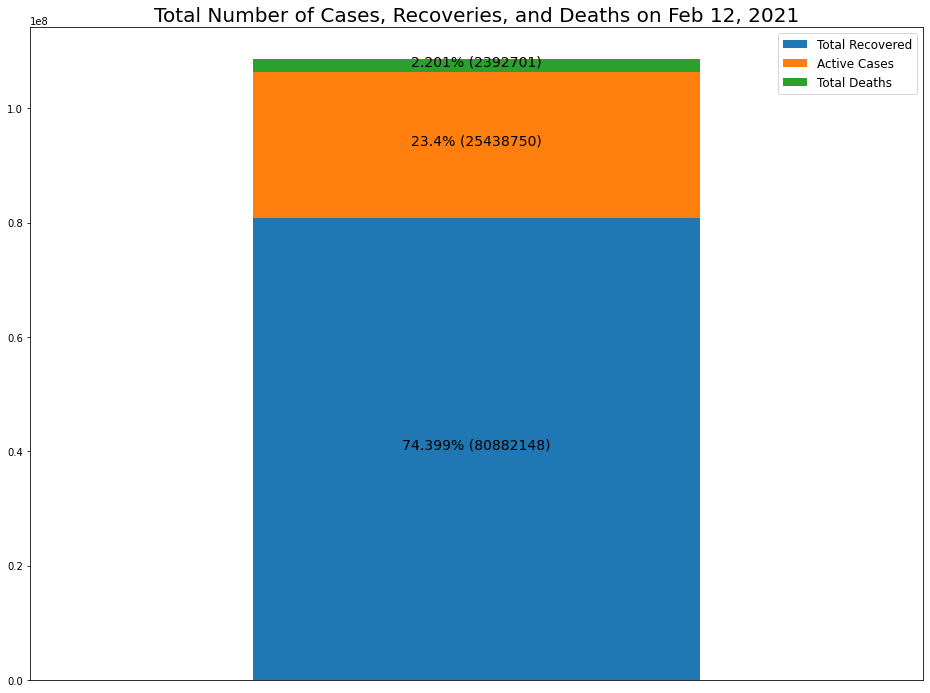

In [16]:
cases_df = df[["Total Recovered", "Active Cases", "Total Deaths"]].loc[0]
pd.DataFrame(cases_df).T.plot.bar(stacked=True, figsize=(16, 12))
plt.xticks(np.arange(0, 0, 1)) # No Ticks
plt.title(f"Total Number of Cases, Recoveries, and Deaths on {yesterday_str}", fontsize=20)
plt.legend(prop={"size": 12})

prev = 0
total = cases_df.sum()
for num in cases_df.cumsum():
    val = round((num-prev)/total*100, 3)
    plt.annotate(f"{val}% ({num-prev})", (0, (num-prev)/2+prev), fontsize=14, ha='center')
    prev = num
plt.show()

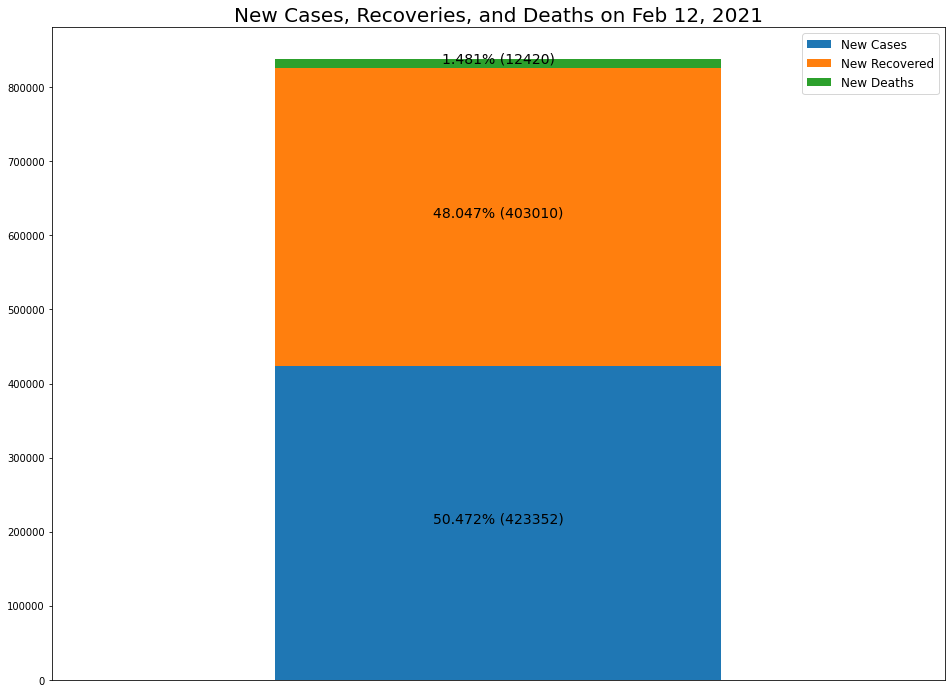

In [17]:
new_df = df[["New Cases", "New Recovered", "New Deaths"]].loc[0]
pd.DataFrame(new_df).T.plot.bar(stacked=True, figsize=(16, 12))
plt.xticks(np.arange(0, 0, 1)) # No Ticks
plt.title(f"New Cases, Recoveries, and Deaths on {yesterday_str}", fontsize=20)
plt.legend(prop={"size": 12})

prev = 0
total = new_df.sum()
for num in new_df.cumsum():
    val = round((num-prev)/total*100, 3)
    plt.annotate(f"{val}% ({round(num-prev)})", (0, (num-prev)/2+prev), fontsize=14, ha='center')
    prev = num
plt.show()

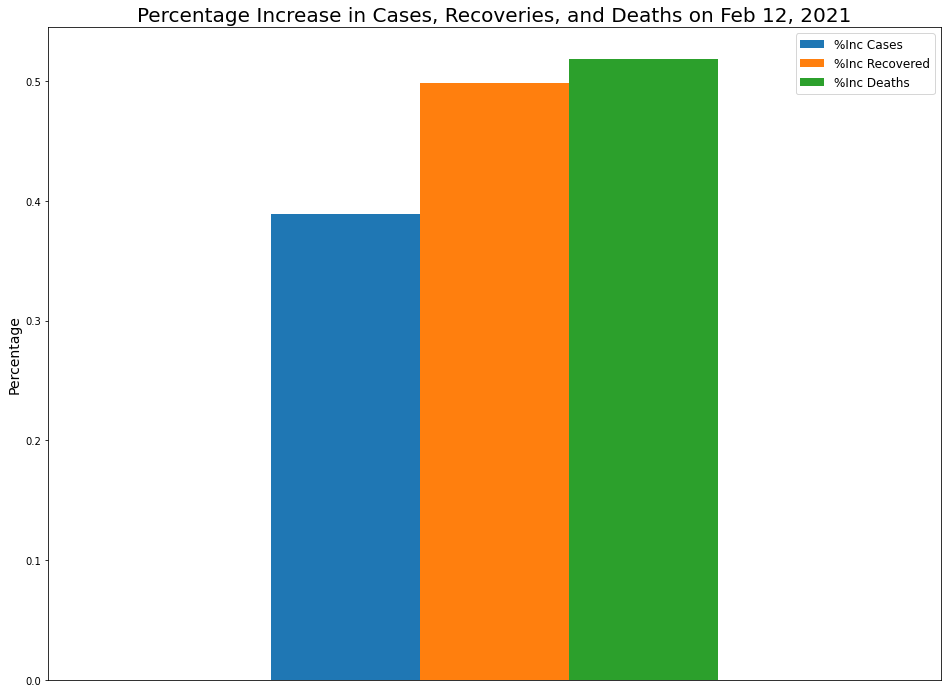

In [18]:
pinc_df = df[["%Inc Cases", "%Inc Recovered", "%Inc Deaths"]].loc[0]
pd.DataFrame(pinc_df).T.plot.bar(figsize=(16, 12))
plt.xticks(np.arange(0, 0, 1)) # No Ticks
plt.title(f"Percentage Increase in Cases, Recoveries, and Deaths on {yesterday_str}", fontsize=20)
plt.ylabel("Percentage", fontsize=14)
plt.legend(prop={"size": 12})
plt.show()

# By Continent

In [19]:
continent_df = df.groupby('Continent').sum().drop('All')
continent_df = continent_df.reset_index()
continent_df

,Continent,Total Cases,New Cases,Total Deaths,New Deaths,Total Recovered,New Recovered,Active Cases,Serious/Critical,Tot Cases/1M,Deaths/1M,Total Tests,Tests/1M,Population,%Inc Cases,%Inc Deaths,%Inc Recovered
0,Africa,3753441,13156.0,97950,511.0,3284079,14750.0,371412,2494,289520.0,4763.5,31321522,2922142,1360232349,21.432011,-164.913673,24.591211
1,Asia,23808602,67449.0,379364,875.0,22324643,65934.0,1104591,22409,786833.0,8149.4,410943608,16780951,3181442580,12.386206,209.883310,13.276321
2,Australia/Oceania,50469,17.0,1075,-7.0,34124,13.0,15267,1,67490.0,517.0,15201435,1131396,41013046,-12.776467,284.038137,-24.693898
3,Europe,32009165,143586.0,760884,4413.0,18446327,129032.0,8207766,27814,2416062.0,46890.0,470802768,43488114,747910820,19.325436,19.354344,17.563625
4,North America,32178949,119708.0,709853,4558.0,21347792,130252.0,10121300,26645,756864.0,11482.0,369019779,14836373,591902566,6.234433,-133.148531,15.695886
5,South America,16809102,79380.0,438819,1983.0,15127337,62898.0,1242945,19954,376801.0,8812.0,67735079,4277290,432954365,5.318756,106.132623,4.808815


In [20]:
cases_vis_list = ['Total Cases', 'Active Cases', 'New Cases', 'Serious/Critical', 'Tot Cases/1M']
deaths_vis_list = ['Total Deaths', 'New Deaths', 'Deaths/1M']
recovered_vis_list = ['Total Recovered', 'New Recovered']
tests_vis_list = ['Total Tests', 'Tests/1M']
essentials = [['Total Cases', 'Active Cases', 'New Cases'], ['Total Deaths', 'New Deaths'], ['Total Recovered', 'New Recovered']]

In [21]:
def continent_visualization(vis_list):
    for label in vis_list:
        pd.DataFrame(continent_df[label]).T.plot.bar(stacked=True, figsize=(16, 12))
        plt.title(f"{label} at the end of {yesterday_str}", fontsize=24)
        plt.xlabel("")
        plt.ylabel(f"{label}", fontsize=16)
        plt.yticks(fontsize=16)
        plt.legend(continent_df['Continent'])

        prev = 0
        total = continent_df[label].sum()
        for num in continent_df[label].cumsum():
            val = round((num-prev)/total*100, 3)
            if val < 1:
                continue
            plt.annotate(f"{val}% ({round(num-prev)})", (0, (num-prev)/2+prev), fontsize=14, ha='center')
            prev = num

        plt.show()
        gc.collect()

## Total Cases lists in the world 2020 - 2021

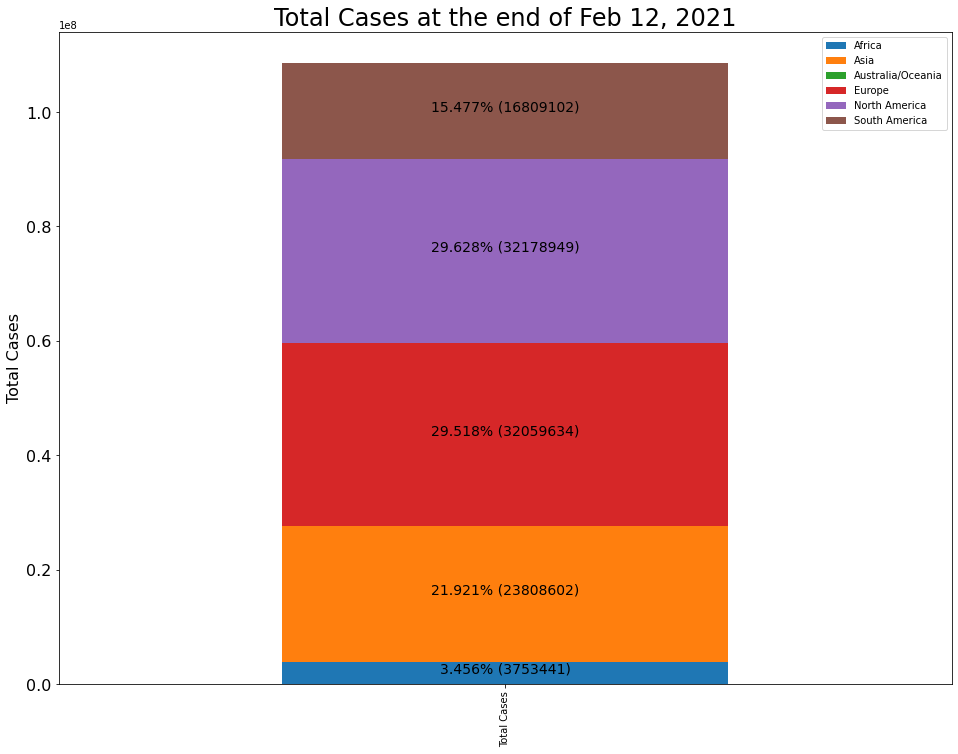

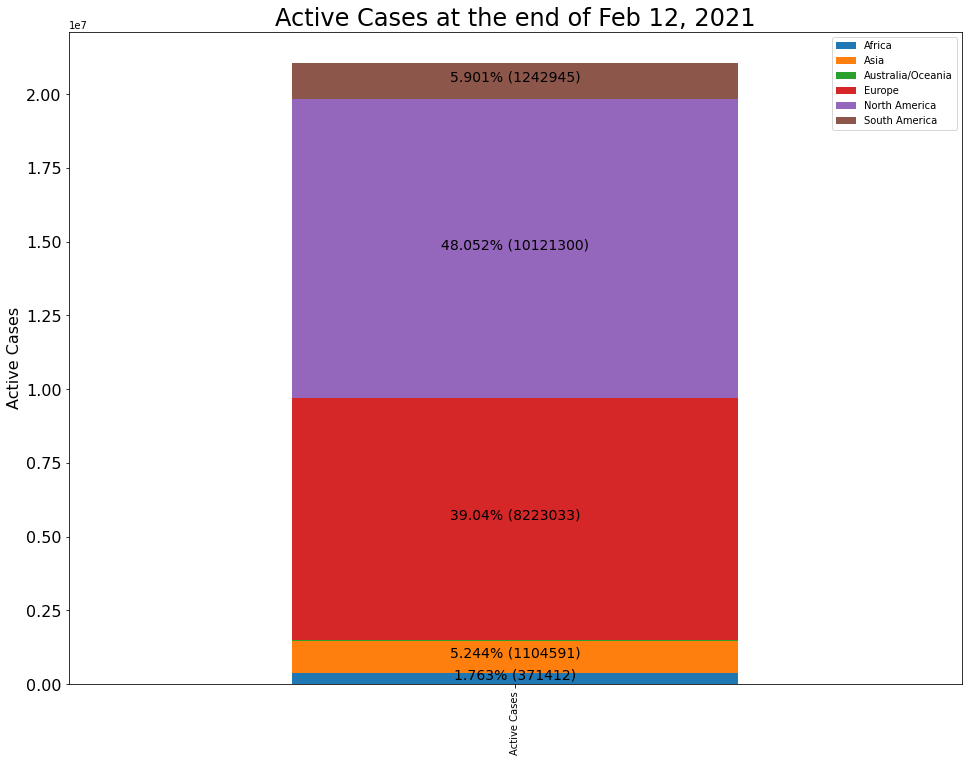

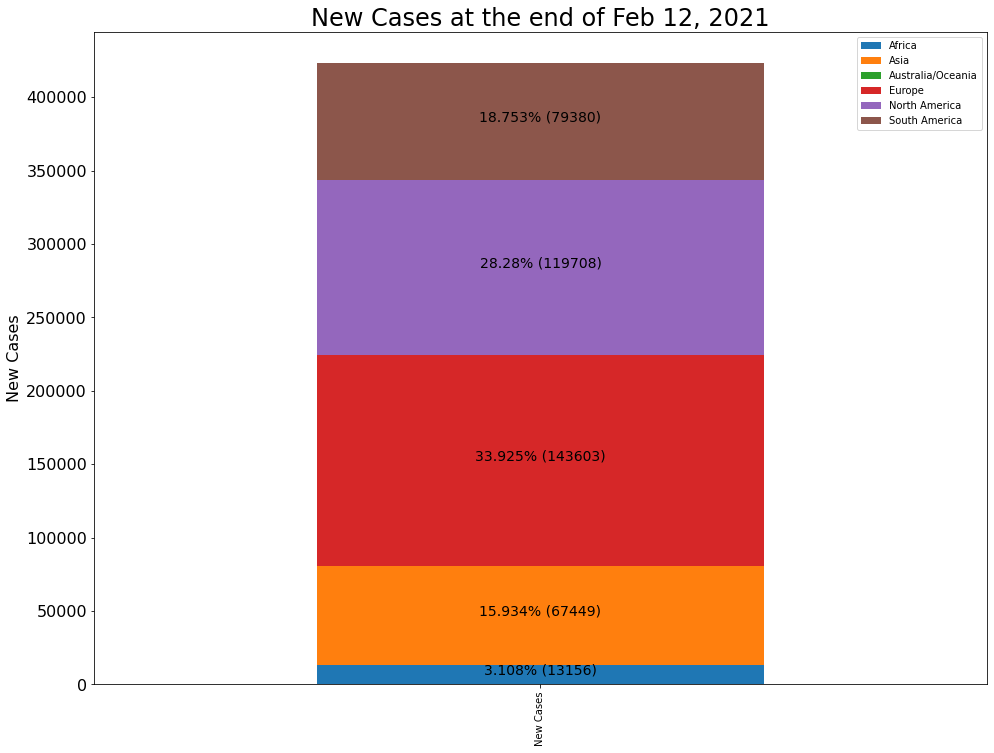

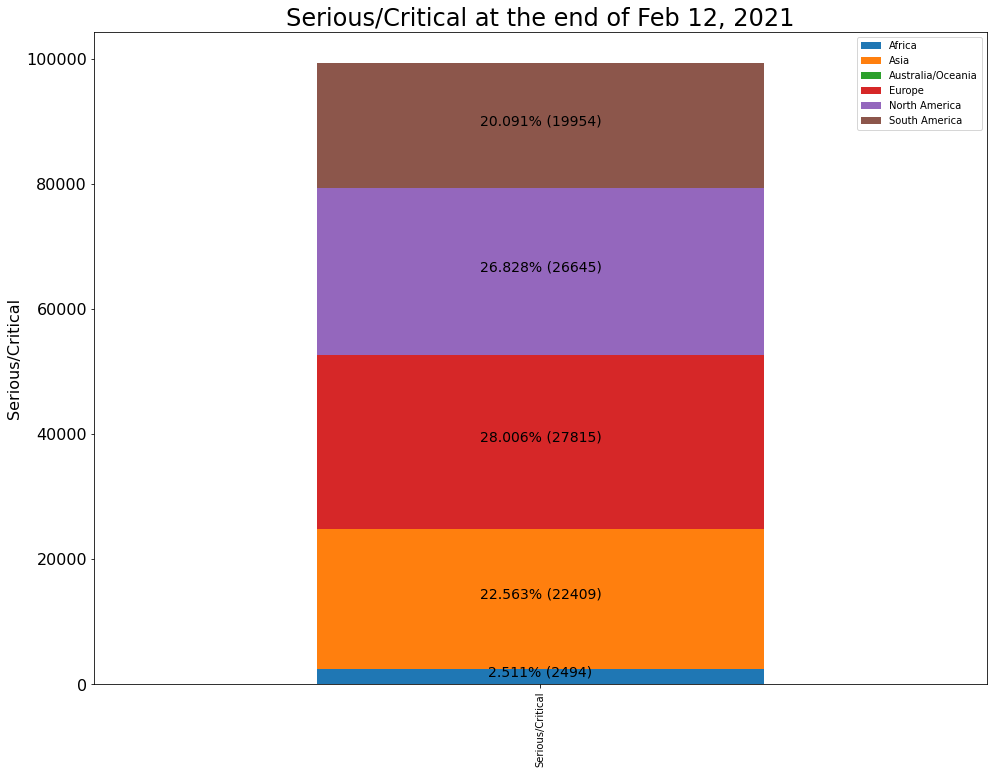

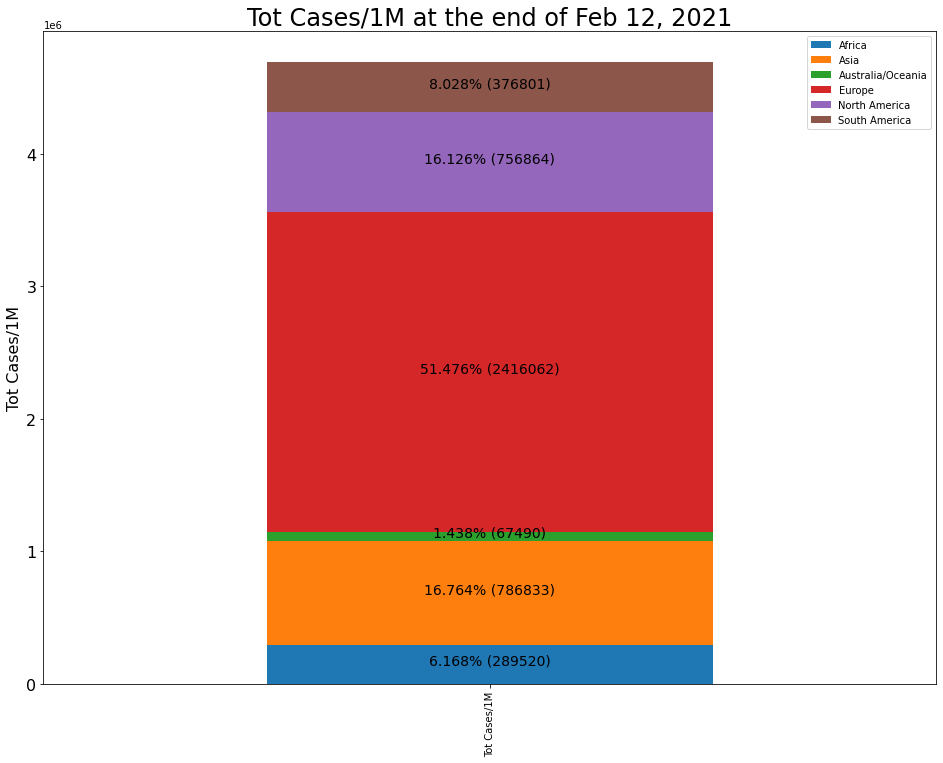

In [22]:
continent_visualization(cases_vis_list)


## Total Deaths lists in the world 2020 - 2021

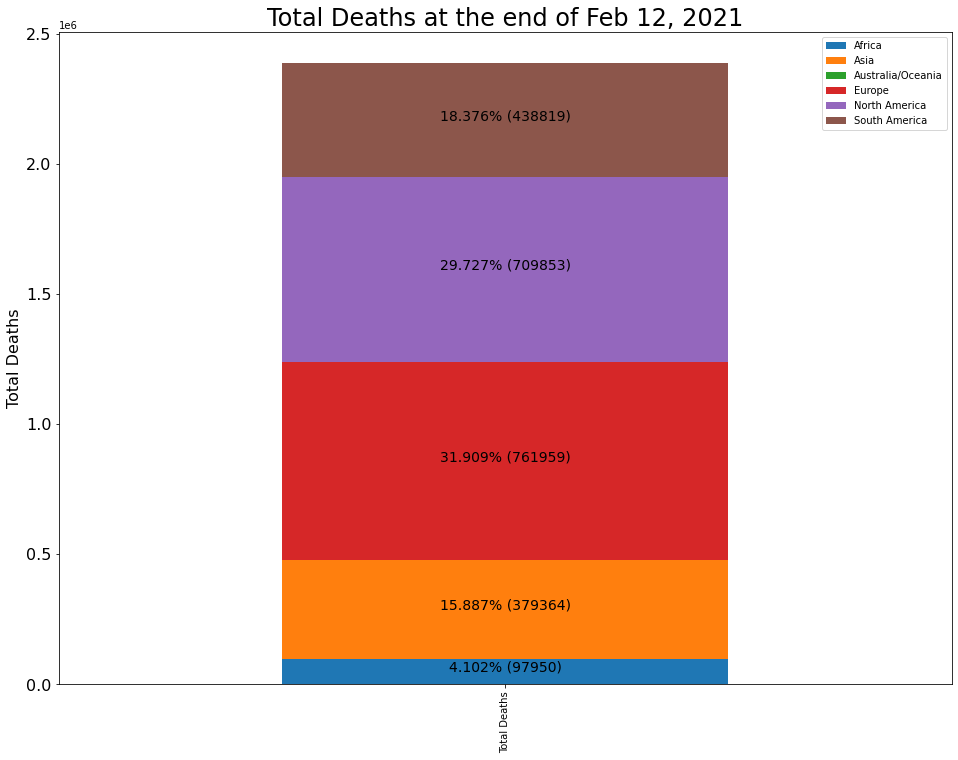

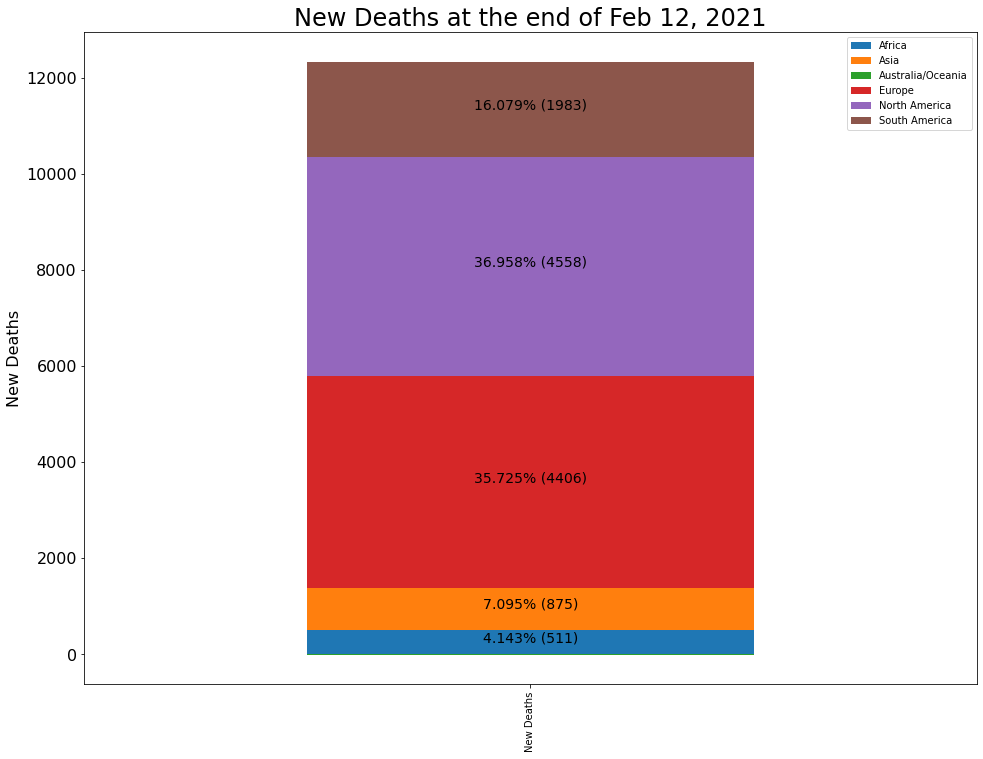

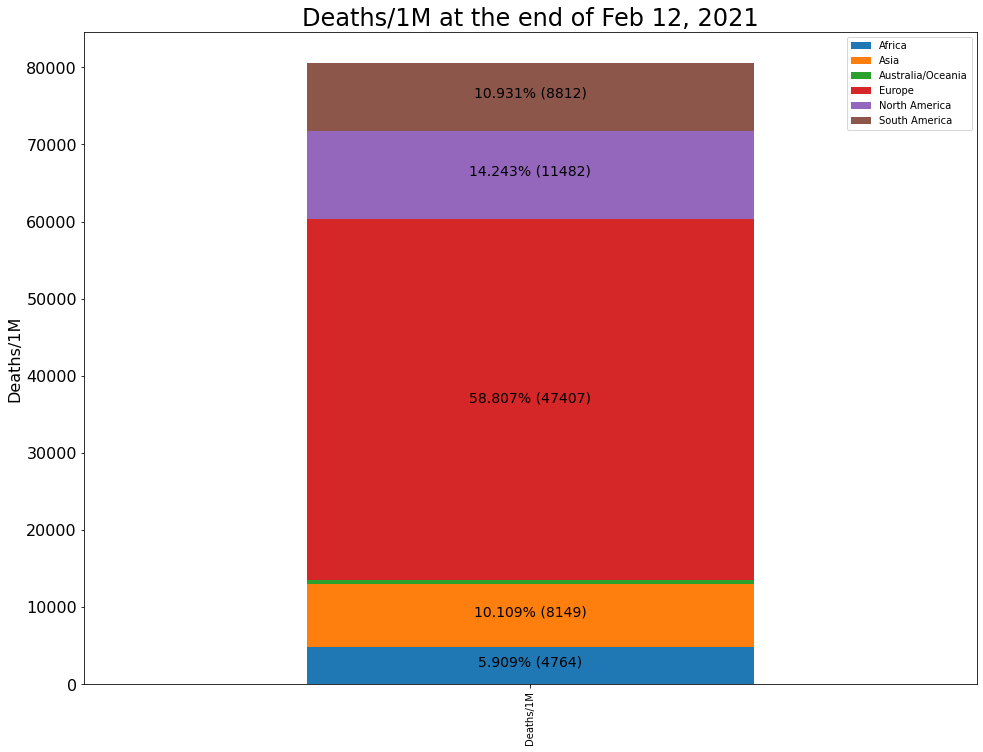

In [23]:
continent_visualization(deaths_vis_list)

## Total Tests lists in the world 2020 - 2021

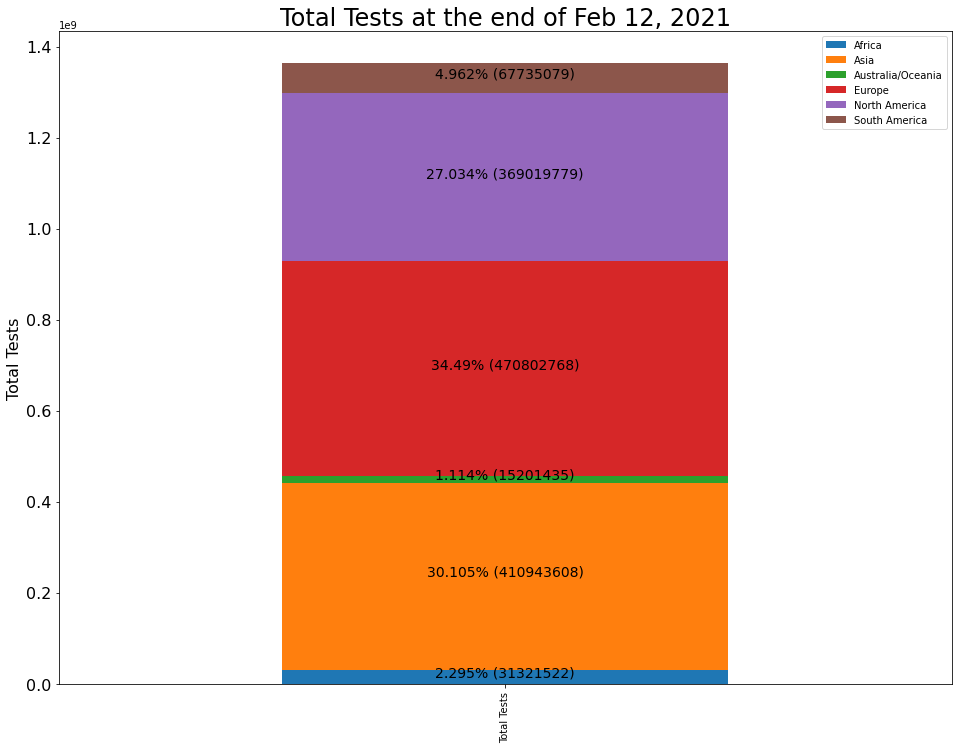

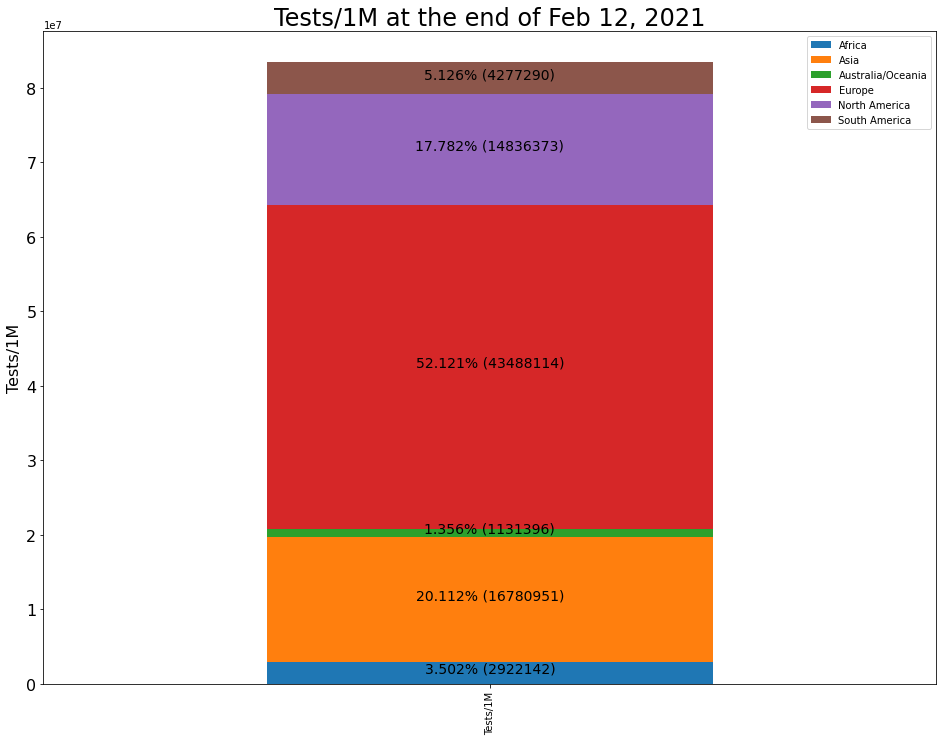

In [24]:
continent_visualization(tests_vis_list)

In [25]:
def continent_visualization2(index, label):
    continent_df.plot.bar(x="Continent", y=essentials[index], stacked=True, figsize=(16, 12))
    plt.title(f"{label} at the end of {yesterday_str}", fontsize=24)
    plt.xlabel("")
    plt.ylabel(f"{label}", fontsize=16)
    plt.yticks(fontsize=16)
    plt.show()
    gc.collect()

## Total Cases in the world 2020 - 2021

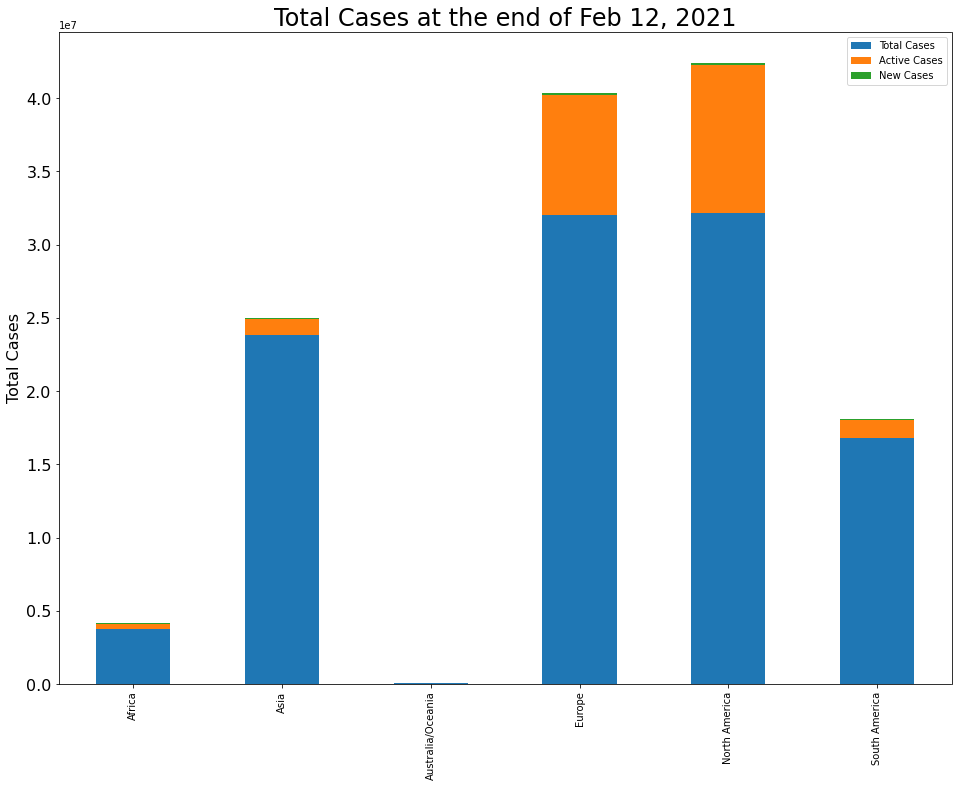

In [26]:
continent_visualization2(0, "Total Cases")

## Total recovereds in the world 2020 - 2021

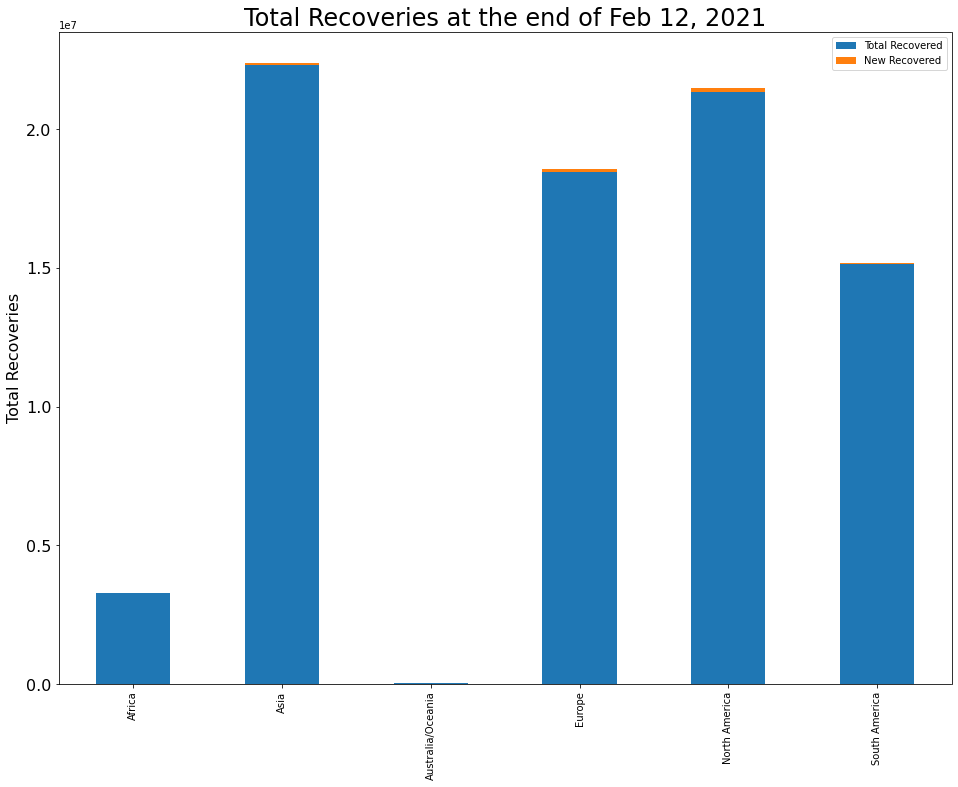

In [27]:
continent_visualization2(2, "Total Recoveries")

## Total Deaths in the world 2020 - 2021

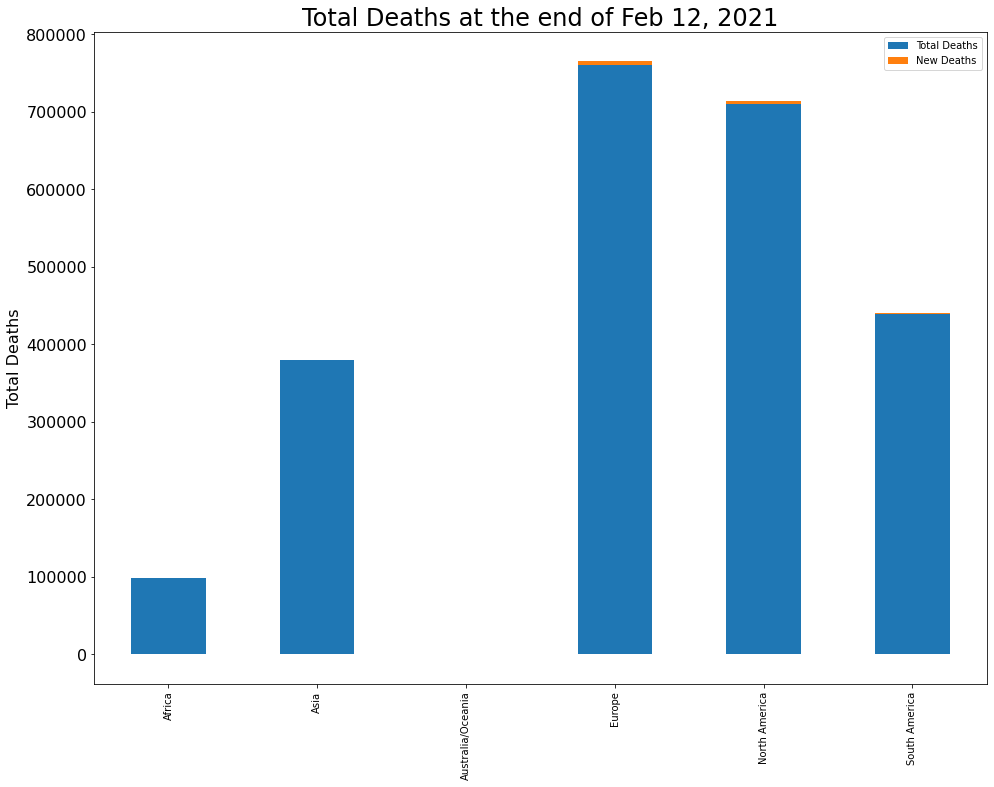

In [28]:
continent_visualization2(1, "Total Deaths")

# By Countries

In [29]:
df = df.drop([len(df)-1])
country_df = df.drop([0])

In [30]:
country_l = country_df.columns[1:14]

fig = go.Figure()
c = 0
for i in country_df.index:
    if c<4:
        fig.add_trace(go.Bar(name=country_df['Country'][i], x=country_l, y=country_df.loc[i][1:14]))
    else:
        break
    c += 1
    
fig.update_layout(title={'text': '4 Countries with Most COVID Cases on %s' % yesterday_str, 'x': 0.5,
                         'xanchor': 'center', 'font': {'size': 20}}, yaxis_title="Percentage", yaxis_type="log", xaxis_tickangle=-90)
fig.show()

In [31]:
inc_l = country_df.columns[15:]
inc_df = country_df.sort_values("%Inc Cases", ascending=False)
fig = go.Figure()
c = 0
for i in inc_df.index:
    if i > 50:
        continue
    if c < 4:
        fig.add_trace(go.Bar(name=country_df['Country'][i], x=inc_l, y=inc_df.loc[i][15:]))
    else:
        break
    c += 1
    
fig.update_layout(title={'text': '4 Countries with Highest Increase in COVID Cases on %s' % yesterday_str, 'x': 0.5,
                         'xanchor': 'center', 'font': {'size': 20}}, yaxis_title="Percentage", xaxis_tickangle=0)
fig.show()

In [32]:
country_labels = country_df.columns[1:14]

def country_visualization(continent):
    buttons_list = []
    base_list = [False for i in range(len(country_df))]
    c = 0
    for i in country_df.index:
        if country_df.loc[i]['Continent'] != continent:
            continue
        tmp_list = base_list.copy()
        tmp_list[c] = True
        c += 1
        buttons_list.append(dict(
                    args=[{"visible": tmp_list}],
                    label=country_df.loc[i]['Country'],
                    method="update"
                ))


    fig = go.Figure()
    c = 0
    for i in country_df.index:
        if country_df.loc[i]['Continent'] != continent:
            continue
        fig.add_trace(go.Bar(name=country_df.loc[i]['Country'], x=country_labels, y=country_df.loc[i][1:14], visible=False if c != 0 else True))
        c += 1

    fig.update_layout(
        updatemenus=[
            dict(
                buttons=buttons_list,
                direction="down",
                pad={"r": 10, "t": 10},
                showactive=True,
                x=0.1,
                xanchor="left",
                y=1.1,
                yanchor="top"
            ),
        ]
    )

    fig.update_layout(title={'text': '%s COVID-19 Cases Search on %s' % (continent, yesterday_str), 'x': 0.5,
                         'xanchor': 'center', 'font': {'size': 20}}, yaxis_type="log", xaxis_tickangle=-90)
    fig.show()

# COVID-19 Cases Search
[Africa](#)

[Asia](#)

[Australia/Oceania](#)

[Europe](#)

[North America](#)

[South America](#)

In [33]:
country_visualization('Africa')

In [34]:
country_visualization('Asia')

In [35]:
country_visualization('Australia/Oceania')

In [36]:
country_visualization('Europe')

In [37]:
country_visualization('North America')

In [38]:
country_visualization('South America')

In [39]:
bar_list = []
for i in country_df.index:
    bar_list.append(go.Bar(name=country_df['Country'][i], y=[country_df['Total Cases'][i]]))
    
fig = go.Figure(data=bar_list)
fig.update_layout(title={'text': 'Stacked Bar Chart of All Countries COVID-19 Cases on %s' % yesterday_str, 'x': 0.5,
                         'xanchor': 'center', 'font': {'size': 20}}, barmode='stack', height=1200)
fig.show()

In [40]:
bar = go.Bar(x=country_df['Country'], y=country_df['Total Cases'], marker=dict(color=df['Total Cases'], colorscale='Reds', showscale=True))
fig = go.Figure(data=[bar])
fig.update_layout(title={'text': 'Number of COVID Cases by Country on %s, log scale' % yesterday_str, 'x': 0.5,
                         'xanchor': 'center', 'font': {'size': 20}}, yaxis_type="log", xaxis_tickangle=-90)

# Statistical Analysis

 * This section is a WIP, I would appreciate any suggestions for this section.

## Concluding Remarks
 * If you've read down this far in the notebook, thank you so much. This notebook took quite a long time to make, but that's aside from the point - these visualizations are for the community, and I'd like this project to also be for the community. So please leave an upvote - it takes literally less than a second - so this notebook/project gains more traction & recognition.

 * And, like I said earlier, if you have any suggestions or code for other visualizations, please let me know in the comments or in DMs. I know I'm not the greatest coder, so everything/anything is appreciated.

 * Stay safe, stay healthy, educate yourself. Thanks!